#Importing Data

In [ ]:
#%pip install pandas matplotlib seaborn statsmodels numpy plotly geopandas


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, Normalize
import seaborn as sns
from statsmodels.tsa.stattools import grangercausalitytests, ccf
import numpy as np
import plotly.express as px
from datetime import datetime
import geopandas as gpd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)
#from utils import *

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Used lates master file from Liezl -- > "master_lagged_features_enriched_filtered.csv" where events minutes aren't incorporated in event columns
# Removed following features: "Duration-1", "Duration-2", "Duration-3", "run_averages_outage_customer_ave", "run_average_outage_minutes"
file_path = '/content/drive/My Drive/Colab Notebooks/ML Project/master_lagged_features_enriched_filtered_IT.csv'
df = pd.read_csv(file_path)
df.head()

,county_fips,date,county,state,lat,lng,population,canopy_cover_percent,overhead_transmission_line,underground_transmission_line,...,temp-1,windspeed-1,precip-1,temp-2,windspeed-2,precip-2,temp-3,windspeed-3,precip-3,population_density
0,45001,8/12/2015,abbeville,south carolina,34.2226,-82.4593,24352,0.58092,40,0,...,27.982083,1.669167,99.368333,27.982083,1.947917,99.547083,28.610833,0.971250,99.585000,19.141814
1,45001,8/13/2015,abbeville,south carolina,34.2226,-82.4593,24352,0.58092,40,0,...,28.179167,1.608333,99.516250,27.982083,1.669167,99.368333,27.982083,1.947917,99.547083,19.141814
2,45001,8/14/2015,abbeville,south carolina,34.2226,-82.4593,24352,0.58092,40,0,...,26.954583,1.476250,99.774583,28.179167,1.608333,99.516250,27.982083,1.669167,99.368333,19.141814
3,45001,10/5/2015,abbeville,south carolina,34.2226,-82.4593,24352,0.58092,40,0,...,19.038750,5.062500,98.757917,15.086667,2.706250,98.411667,15.890000,3.384583,98.924583,19.141814
4,45001,10/6/2015,abbeville,south carolina,34.2226,-82.4593,24352,0.58092,40,0,...,16.902917,3.466250,99.480417,19.038750,5.062500,98.757917,15.086667,2.706250,98.411667,19.141814


In [ ]:
# Get the shape (rows, columns)
df.shape

(494309, 60)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494309 entries, 0 to 494308
Data columns (total 60 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   county_fips                    494309 non-null  int64  
 1   date                           494309 non-null  object 
 2   county                         494309 non-null  object 
 3   state                          494309 non-null  object 
 4   lat                            494309 non-null  float64
 5   lng                            494309 non-null  float64
 6   population                     494309 non-null  int64  
 7   canopy_cover_percent           494309 non-null  float64
 8   overhead_transmission_line     494309 non-null  int64  
 9   underground_transmission_line  494309 non-null  int64  
 10  social_vulnerability_percent   494309 non-null  float64
 11  outage_customer_ave            494309 non-null  float64
 12  outage_minutes                

#Analysing main dataset

##Creating subset of data for ChatGPT processing

In [ ]:
# #To select first 100,000 rows
# sample_df = df.iloc[:100000]

# # Save to a folder in Google Drive
# output_path = "/content/drive/My Drive/Colab Notebooks/ML Project/sample_df_rf_xgboost.csv"
# sample_df.to_csv(output_path, index=False)


In [ ]:
df.describe()

,county_fips,lat,lng,population,canopy_cover_percent,overhead_transmission_line,underground_transmission_line,social_vulnerability_percent,outage_customer_ave,outage_minutes,...,temp-1,windspeed-1,precip-1,temp-2,windspeed-2,precip-2,temp-3,windspeed-3,precip-3,population_density
count,494309.000000,494309.000000,494309.000000,4.943090e+05,494309.000000,494309.000000,494309.000000,494309.000000,494309.000000,494309.000000,...,494309.000000,494309.000000,494309.000000,494309.000000,494309.000000,494309.000000,494309.000000,494309.000000,494309.000000,494309.000000
mean,30425.334572,37.879601,-90.922323,1.540997e+05,0.293587,37.603574,0.218131,22.583337,217.608646,478.500331,...,19.022514,4.604589,91.708104,19.641013,4.676342,91.685936,19.897183,4.570249,91.656238,128.548466
std,15035.900848,4.727699,11.212284,4.209393e+05,0.239797,45.247307,1.568044,5.437690,3590.297786,523.780714,...,8.378820,4.733858,21.600741,8.059849,4.773825,21.522832,7.944377,4.595160,21.735744,783.715026
min,1001.000000,19.598400,-159.596100,5.200000e+01,0.000000,0.000000,0.000000,9.370000,0.000000,0.000000,...,-27.845000,0.385833,0.000000,-27.845000,0.385833,0.000000,-27.845000,0.352500,0.000000,0.013765
25%,19041.000000,34.530800,-97.142700,1.358700e+04,0.061040,12.000000,0.000000,18.750000,0.000000,0.000000,...,14.396667,2.209167,95.412083,15.550833,2.237083,95.378750,15.952917,2.183750,95.401667,8.184692
50%,29151.000000,37.939100,-90.131400,3.460800e+04,0.255630,24.000000,0.000000,22.080000,4.000000,255.000000,...,21.254583,3.388750,98.052500,21.708750,3.452500,98.002083,21.837500,3.385000,98.037500,20.808725
75%,46005.000000,41.334300,-83.024400,1.093930e+05,0.501430,45.000000,0.000000,25.880000,35.282051,885.000000,...,25.111250,5.055417,99.786667,25.387083,5.158750,99.734167,25.540417,5.090000,99.770417,65.987464
max,56045.000000,61.149800,-67.628700,9.848406e+06,0.988110,490.000000,30.000000,46.430000,865675.434800,1440.000000,...,39.630417,90.757850,243.900020,39.630417,90.757850,243.900020,39.630417,90.757850,216.699980,27738.248180


#Removing "county" and "state" "columns"

In [ ]:
# Remove columns state and county from df

df = df.drop(columns=['state', 'county'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494309 entries, 0 to 494308
Data columns (total 58 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   county_fips                    494309 non-null  int64  
 1   date                           494309 non-null  object 
 2   lat                            494309 non-null  float64
 3   lng                            494309 non-null  float64
 4   population                     494309 non-null  int64  
 5   canopy_cover_percent           494309 non-null  float64
 6   overhead_transmission_line     494309 non-null  int64  
 7   underground_transmission_line  494309 non-null  int64  
 8   social_vulnerability_percent   494309 non-null  float64
 9   outage_customer_ave            494309 non-null  float64
 10  outage_minutes                 494309 non-null  int64  
 11  temp                           494309 non-null  float64
 12  windspeed                     

In [ ]:
df.shape

(494309, 58)

In [ ]:
df.head()

,county_fips,date,lat,lng,population,canopy_cover_percent,overhead_transmission_line,underground_transmission_line,social_vulnerability_percent,outage_customer_ave,...,temp-1,windspeed-1,precip-1,temp-2,windspeed-2,precip-2,temp-3,windspeed-3,precip-3,population_density
0,45001,8/12/2015,34.2226,-82.4593,24352,0.58092,40,0,27.19,0.000000,...,27.982083,1.669167,99.368333,27.982083,1.947917,99.547083,28.610833,0.971250,99.585000,19.141814
1,45001,8/13/2015,34.2226,-82.4593,24352,0.58092,40,0,27.19,0.000000,...,28.179167,1.608333,99.516250,27.982083,1.669167,99.368333,27.982083,1.947917,99.547083,19.141814
2,45001,8/14/2015,34.2226,-82.4593,24352,0.58092,40,0,27.19,0.000000,...,26.954583,1.476250,99.774583,28.179167,1.608333,99.516250,27.982083,1.669167,99.368333,19.141814
3,45001,10/5/2015,34.2226,-82.4593,24352,0.58092,40,0,27.19,273.142857,...,19.038750,5.062500,98.757917,15.086667,2.706250,98.411667,15.890000,3.384583,98.924583,19.141814
4,45001,10/6/2015,34.2226,-82.4593,24352,0.58092,40,0,27.19,2.222222,...,16.902917,3.466250,99.480417,19.038750,5.062500,98.757917,15.086667,2.706250,98.411667,19.141814


#Removing "outage_customer_ave" and "outage" columns

In [ ]:
#Remove the column "outage_customer_ave" from the df DataFrame:
df = df.drop(columns=["outage_customer_ave"])
df = df.drop(columns=["outage"])

print(df.columns)

KeyError: "['outage_customer_ave'] not found in axis"

# Splitting Train/Test Set

##Spliting randomly

In [ ]:
np.random.seed(42)

In [ ]:
# #Split Data
# from sklearn.model_selection import train_test_split

# train_set, test_set = train_test_split(df, test_size=0.3, random_state=42)

In [ ]:
# train_set.shape

(346016, 55)

In [ ]:
# len(train_set)

346016

In [ ]:
# len(test_set)

148293

##Spliting time-based

In [ ]:
# Time-based split

# Ensure 'date' is in datetime format
df["date"] = pd.to_datetime(df["date"])

# Sort the DataFrame by date
df_sorted = df.sort_values(by="date").reset_index(drop=True)

# Step 3: Calculate split index
split_index = int(len(df_sorted) * 0.7)

# Split into train and test sets
train_set = df_sorted.iloc[:split_index].copy()
test_set = df_sorted.iloc[split_index:].copy()

# Step 5: Drop the 'date' column
train_set.drop(columns=["date"], inplace=True)
test_set.drop(columns=["date"], inplace=True)

# Optional: Confirm split
print("Train size:", len(train_set))
print("Test size:", len(test_set))


Train size: 346016
Test size: 148293


#Defining target variable

In [ ]:
#Separating data into:
#Variable to be predicted (the target).
#Variables to be used to make the prediction (the features).

target = 'outage_minutes'
features = list(train_set.columns)
features = [f for f in features if f!=target]

In [ ]:
X_tr = train_set[features]
y_tr = train_set[[target]]

X_te = test_set[features]
y_te = test_set[[target]]

In [ ]:
print(X_tr.shape)
print(X_te.shape)

(346016, 54)
(148293, 54)


In [ ]:
from re import X
# print(X_tr)
# print(y_te.shape)
X_tr.head()
X_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346016 entries, 0 to 346015
Data columns (total 54 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   county_fips                    346016 non-null  int64  
 1   lat                            346016 non-null  float64
 2   lng                            346016 non-null  float64
 3   population                     346016 non-null  int64  
 4   canopy_cover_percent           346016 non-null  float64
 5   overhead_transmission_line     346016 non-null  int64  
 6   underground_transmission_line  346016 non-null  int64  
 7   social_vulnerability_percent   346016 non-null  float64
 8   temp                           346016 non-null  float64
 9   windspeed                      346016 non-null  float64
 10  precip                         346016 non-null  float64
 11  median_income                  346016 non-null  int64  
 12  poverty_percent               

#Scaling features

In [ ]:
#Tree-based algorithms don't require scalling

In [ ]:
from sklearn.preprocessing import StandardScaler
# Initialize the StandardScaler
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Fit and transform the training features (X_tr)
X_tr_scaled = scaler_X.fit_transform(X_tr)
# Fit and transform the training target (y_tr)
y_tr_scaled = scaler_y.fit_transform(y_tr)


# Transform test features (X_te)
X_te_scaled = scaler_X.transform(X_te)
# Transform test target (y_te)
y_te_scaled = scaler_y.transform(y_te)

In [ ]:
print(X_tr_scaled.shape)

(346016, 54)


#Building model

##Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.model_selection import GridSearchCV

In [ ]:
#Best hyper parameters based on Liezl tunning:
# {'n_estimators': 200,
#  'min_samples_split': 10,
#  'min_samples_leaf': 2,
#  'max_features': 'sqrt',
#  'max_depth': 50,
#  'bootstrap': True}

rf = RandomForestRegressor(n_estimators=200, random_state=42, min_samples_split=10, min_samples_leaf=2, max_depth=50, bootstrap=True, max_features='sqrt', n_jobs=-1)
rf.fit(X_tr, y_tr.values.ravel())  # Flatten y_tr to 1D

RandomForestRegressor(max_depth=50, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=10, n_estimators=200, n_jobs=-1,
                      random_state=42)

In [ ]:
# Predict and evaluate
y_pred = rf.predict(X_te)
rmse = mean_squared_error(y_te, y_pred) ** 0.5
r2 = r2_score(y_te, y_pred)

print(f"RMSE: {rmse}")
print(f"R2 Score: {r2}")

RMSE: 419.99811550102584
R2 Score: 0.3906928442217612


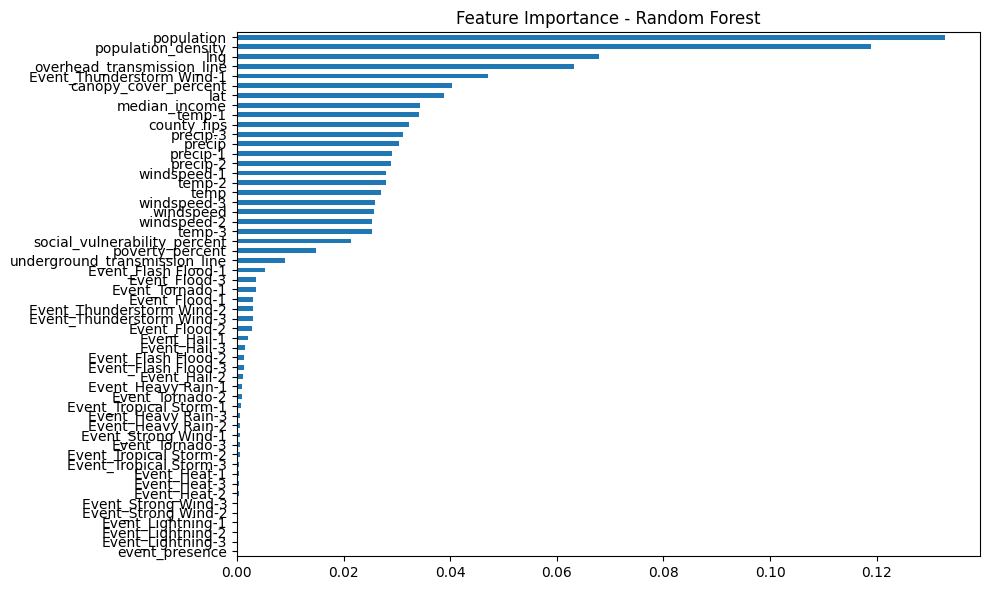

In [ ]:
#Plot feature importances
importances = pd.Series(rf.feature_importances_, index=features)
importances.sort_values().plot(kind='barh', figsize=(10, 6))
plt.title("Feature Importance - Random Forest")
plt.tight_layout()
plt.show()

###Learnign cureve for Random Forest

In [ ]:
# from sklearn.model_selection import learning_curve

# train_sizes, train_scores, val_scores = learning_curve(
#     estimator=RandomForestRegressor(),
#     X=X_tr,
#     y=y_tr,
#     cv=4,
#     scoring='neg_mean_squared_error',
#     train_sizes=np.linspace(0.1, 1.0, 10),
#     shuffle=True,
#     random_state=42
# )

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


KeyboardInterrupt: 

In [ ]:
# train_rmse = np.sqrt(-train_scores)
# val_rmse = np.sqrt(-val_scores)

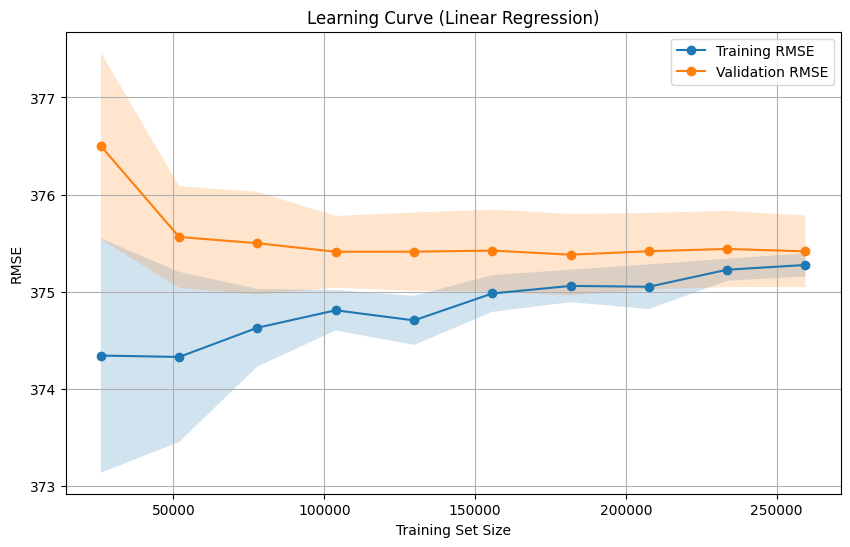

In [ ]:
# plt.figure(figsize=(10, 6))
# plt.plot(train_sizes, train_rmse.mean(axis=1), 'o-', label='Training RMSE')
# plt.plot(train_sizes, val_rmse.mean(axis=1), 'o-', label='Validation RMSE')
# plt.fill_between(train_sizes,
#                  train_rmse.mean(axis=1) - train_rmse.std(axis=1),
#                  train_rmse.mean(axis=1) + train_rmse.std(axis=1),
#                  alpha=0.2)
# plt.fill_between(train_sizes,
#                  val_rmse.mean(axis=1) - val_rmse.std(axis=1),
#                  val_rmse.mean(axis=1) + val_rmse.std(axis=1),
#                  alpha=0.2)
# plt.title("Learning Curve (Linear Regression)")
# plt.xlabel("Training Set Size")
# plt.ylabel("RMSE")
# plt.legend()
# plt.grid(True)
# plt.show()

##Linear regression without scaling

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

def display_scores(name, scores):
    print(f"{name} Scores:", scores)
    print(f"{name} Mean:", scores.mean())
    print(f"{name} Std deviation:", scores.std())
    print("-" * 40)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate

# Perform cross-validation with both RMSE and R²
lin_scores = cross_validate(
    LinearRegression(),
    train_set[features],
    train_set[target],
    scoring=["neg_mean_squared_error", "r2"],
    cv=4
)

# Convert negative MSE to RMSE
lin_rmse_scores = np.sqrt(-lin_scores["test_neg_mean_squared_error"])
lin_r2_scores = lin_scores["test_r2"]

# Display both metrics
display_scores("RMSE", lin_rmse_scores)
display_scores("R²", lin_r2_scores)

RMSE Scores: [424.89114    419.32602049 425.73911123 452.23131477]
RMSE Mean: 430.54689662162207
RMSE Std deviation: 12.759549708728258
----------------------------------------
R² Scores: [0.19855129 0.29945221 0.31655379 0.27778768]
R² Mean: 0.27308624438139373
R² Std deviation: 0.04517232116910951
----------------------------------------


In [ ]:
pd.Series(lin_rmse_scores).describe()

,0
count,4.000000
mean,430.546897
std,14.733459
min,419.326020
25%,423.499860
50%,425.315126
75%,432.362162
max,452.231315


##Linear regression with scaling

In [ ]:
# Define scoring display function
def display_scores(name, scores):
    print(f"{name} Scores:", scores)
    print(f"{name} Mean:", scores.mean())
    print(f"{name} Std deviation:", scores.std())
    print("-" * 40)

In [ ]:
# Cross-validate on scaled data
lin_scores = cross_validate(
    LinearRegression(),
    X_tr_scaled,
    y_tr,
    scoring=["neg_mean_squared_error", "r2"],
    cv=4
)

# Convert MSE to RMSE (still in scaled units)
lin_rmse_scores = np.sqrt(-lin_scores["test_neg_mean_squared_error"])
lin_r2_scores = lin_scores["test_r2"]

# Display
display_scores("RMSE (scaled)", lin_rmse_scores)
display_scores("R²", lin_r2_scores)

RMSE (scaled) Scores: [424.89114    419.32602049 425.73911123 452.23131478]
RMSE (scaled) Mean: 430.5468966225718
RMSE (scaled) Std deviation: 12.759549710132658
----------------------------------------
R² Scores: [0.19855129 0.29945221 0.31655379 0.27778768]
R² Mean: 0.27308624437861484
R² Std deviation: 0.0451723211642191
----------------------------------------


###Learning curve for Linear regression

In [ ]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    estimator=LinearRegression(),
    X=X_tr_scaled,
    y=y_tr,
    cv=4,
    scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 10),
    shuffle=True,
    random_state=42
)

In [ ]:
train_rmse = np.sqrt(-train_scores)
val_rmse = np.sqrt(-val_scores)

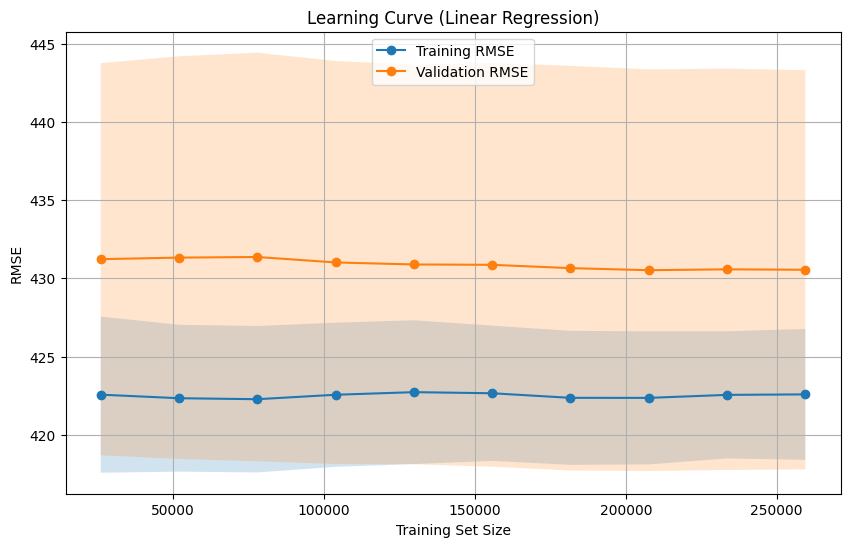

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_rmse.mean(axis=1), 'o-', label='Training RMSE')
plt.plot(train_sizes, val_rmse.mean(axis=1), 'o-', label='Validation RMSE')
plt.fill_between(train_sizes,
                 train_rmse.mean(axis=1) - train_rmse.std(axis=1),
                 train_rmse.mean(axis=1) + train_rmse.std(axis=1),
                 alpha=0.2)
plt.fill_between(train_sizes,
                 val_rmse.mean(axis=1) - val_rmse.std(axis=1),
                 val_rmse.mean(axis=1) + val_rmse.std(axis=1),
                 alpha=0.2)
plt.title("Learning Curve (Linear Regression)")
plt.xlabel("Training Set Size")
plt.ylabel("RMSE")
plt.legend()
plt.grid(True)
plt.show()

##XGBoost Regressor

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

# Initialize and train XGBoost regressor
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    objective='reg:squarederror',
    random_state=42
)

xgb_model.fit(X_tr, y_tr)

# Step 3: Predict and evaluate
y_pred = xgb_model.predict(X_te)

rmse = np.sqrt(mean_squared_error(y_te, y_pred))
r2 = r2_score(y_te, y_pred)

print(f"XGBoost RMSE: {rmse:.2f}")
print(f"XGBoost R² Score: {r2:.2f}")

XGBoost RMSE: 426.32
XGBoost R² Score: 0.37


##Ridge regression

In [ ]:
from sklearn.linear_model import Ridge
param_grid = [{'alpha': [0.001,0.01,0.1,1,10,100,1000,10000]}]
grid_search_rr = GridSearchCV(Ridge(), param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search_rr.fit(X_tr_scaled, y_tr)

GridSearchCV(cv=3, estimator=Ridge(),
             param_grid=[{'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000,
                                    10000]}],
             scoring='neg_mean_squared_error')

In [ ]:
print(grid_search_rr.best_params_)
print(np.sqrt(-grid_search_rr.best_score_))

{'alpha': 100}
456.0556352620425


##Lasso regression

In [ ]:
from sklearn.linear_model import Lasso
param_grid = [{'alpha': [0.001,0.01,0.1,1,10,100,1000,10000]}]
grid_search_lasso = GridSearchCV(Lasso(), param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search_lasso.fit(X_tr_scaled, y_tr)

GridSearchCV(cv=3, estimator=Lasso(),
             param_grid=[{'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000,
                                    10000]}],
             scoring='neg_mean_squared_error')

In [ ]:
print(grid_search_lasso.best_params_)
print(np.sqrt(-grid_search_lasso.best_score_))

{'alpha': 1}
456.0526734140248


##Elastic Net regression

In [ ]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

param_grid = [
    {
        'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
        'l1_ratio': [0.2, 0.4, 0.6]
    }
]

grid_search_elasticnet = GridSearchCV(ElasticNet(), param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search_elasticnet.fit(X_tr_scaled, y_tr)

GridSearchCV(cv=3, estimator=ElasticNet(),
             param_grid=[{'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
                          'l1_ratio': [0.2, 0.4, 0.6]}],
             scoring='neg_mean_squared_error')

In [ ]:
print(grid_search_elasticnet.best_params_)
print(np.sqrt(-grid_search_elasticnet.best_score_))

{'alpha': 0.01, 'l1_ratio': 0.2}
456.0551340965169


##Support Vector Machines

In [ ]:
# from sklearn.svm import SVR

# C_vals = [100, 1000, 3000000]  # Regularization parameter
# gamma_vals = [0.02, 0.03, 0.04]  # RBF kernel coefficient


# param_grid = [{'C':C_vals, 'gamma':gamma_vals}]
# grid_search_rbf = GridSearchCV(SVR(kernel='rbf'), param_grid, cv=3,scoring='neg_mean_squared_error')
# grid_search_rbf.fit(X_tr, np.ravel(y_tr))